Probabilistic Roadmap Planners (PRM)
====================================

**Topic**: Introduction to PRM planners

Version | Author
------------ | -------------
0.2 | Björn Hein


This worksheet **shows an example for a basic probabilistic roadmap planner (PRM)** 


License is based on Creative Commons: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) (pls. check: http://creativecommons.org/licenses/by-nc/4.0/)

This work-sheet should include all necessary incredience to implement different PRM algorithm for path planning applications in Python.

**Attention**: This worksheet has external dependencies 

Important links are:

    General Info: http://www.python.org
    Python tutorial http://www.python.org/doc/tut/
    NetworkX http://networkx.github.io/
    NumPy and SciPy Guide http://docs.scipy.org/
    Matplotlib gallery http://matplotlib.sourceforge.net/gallery.html

Remember that:

    you have to press ctrl-return or shift-return, to execute the code in the code sections, only then the variables are "generated" and can be used
    you can execute the whole notebook by Cell->runAll






Setting up a basic PRM-Algorithm
===============================

Needed functionality
--------------------

* Random position generator (Sampling strategy)
* Computation of **nearest neighbours** for a given node
* Test of connected components
* Collision test (point and **line**): Please take care, we also need a **line test**.

Please check notebook IP-5-0-PRM_Basics.ipynb for information and explanation about these topics


PRM Basic
===========

Following a simplified version of the classical PRM:

* no sophisticated way of searching nearest neighbours (just brute-force) AND don't care about the order
* no sophisticated way to detect complicated areas


Definition of a base class for PRMs
======================================

see file IPPlanerBase.py:

```
from IPPlanerBase import PlanerBase
class PRMBase(PlanerBase):
    
    def __init__(self,_collChecker):
        super(PRMBase,self).__init__(_collChecker)

    def _getRandomPosition(self):
        limits = self.collChecker.getWorldLimits()        
        pos = [random.uniform(limit[0],limit[1]) for limit in limits]
        return pos
    
    def _getRandomFreePosition(self):
        pos = self._getRandomPosition()
        while self.collChecker.isInCollision(pos):
            pos = self._getRandomPosition()
        return pos
```

Based on the base class mentioned before, the PRM algorithm can be implemented in the following way:

In [1]:
import IPPRMBase
import networkx as nx
import random
import numpy as np
import math

# reduce coding effort by using function provided by scipy
from scipy.spatial.distance import euclidean, cityblock

class BasicPRM(IPPRMBase.PRMBase):

    def __init__(self, _collChecker):
        super(BasicPRM, self).__init__(_collChecker)
        self.graph = nx.Graph()

    
    def _inSameConnectedComponent(self, node1, node2):
        """ Check whether to nodes are part of the same connected component using
            functionality from NetworkX
        """
        for connectedComponent in nx.connected_components(self.graph):
            if (node1 in connectedComponent) & (node2 in connectedComponent):
                return True

        return False

    
    def _nearestNeighbours(self, pos, radius):
        """ Brute Force method to find all nodes of a 
        graph near the given position **pos** with in the distance of
        **radius** """

        result = list()
        for node in self.graph.nodes(data=True):
            if euclidean(node[1]['pos'],pos) <= radius:
                result.append(node)

        return result
    
    def _learnRoadmapNearestNeighbour(self, radius, numNodes):
        """ Generate a roadmap by given number of nodes and radius, that should be tested for connection."""
        # nodeID is used for uniquely enumerating all nodes and as their name
        nodeID = 1
        while nodeID <= numNodes:
        
            # Generate a 'randomly chosen, free configuration'
            newNodePos = self._getRandomFreePosition()
            self.graph.add_node(nodeID, pos=newNodePos)
            
            # Find set of candidates to connect to sorted by distance
            result = self._nearestNeighbours(newNodePos, radius)

            # for all nearest neighbours check whether a connection is possible
            for data in result:
                if self._inSameConnectedComponent(nodeID,data[0]):
                    break
                
                if not self._collisionChecker.lineInCollision(newNodePos,data[1]['pos']):
                    self.graph.add_edge(nodeID,data[0])
            
            nodeID += 1
            
    def planPath(self, startList, goalList, config):
        """
        
        Args:
            start (array): start position in planning space
            goal (array) : goal position in planning space
            config (dict): dictionary with the needed information about the configuration options
            
        Example:
        
            config["radius"]   = 5.0
            config["numNodes"] = 300
            config["useKDTree"] = True
            
            startList = [[1,1]]
            goalList  = [[10,1]]
            
            instance.planPath(startList,goalList,config)
        
        """
        # 0. reset
        self.graph.clear()
        
        # 1. check start and goal whether collision free (s. BaseClass)
        checkedStartList, checkedGoalList = self._checkStartGoal(startList,goalList)
        
        # 2. learn Roadmap
        self._learnRoadmapNearestNeighbour(config["radius"],config["numNodes"])

        # 3. find connection of start and goal to roadmap
        # find nearest, collision-free connection between node on graph and start
        result = self._nearestNeighbours(checkedStartList[0], config["radius"])
        for node in result:
            if not self._collisionChecker.lineInCollision(checkedStartList[0],node[1]['pos']):
                 self.graph.add_node("start", pos=checkedStartList[0], color='lightgreen')
                 self.graph.add_edge("start", node[0])
                 break

        result = self._nearestNeighbours(checkedGoalList[0], config["radius"])
        for node in result:
            if not self._collisionChecker.lineInCollision(checkedGoalList[0],node[1]['pos']):
                 self.graph.add_node("goal", pos=checkedGoalList[0], color='lightgreen')
                 self.graph.add_edge("goal", node[0])
                 break

        try:
            path = nx.shortest_path(self.graph,"start","goal")
        except:
            return []
        return path

## Visualizing the information

In [2]:
import matplotlib.pyplot as plt
def basicPRMVisualize(graph, collChecker, solution, nodeSize=100.0, ax=None):
    # get a list of posiations of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    
    # draw graph (nodes colorized by degree)
    nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    nx.draw_networkx_edges(graph,pos,
                                ax = ax
                                 )
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    G0=graph.subgraph(Gcc[0])# = largest connected component

    # how largest connected component
    nx.draw_networkx_edges(G0,pos,
                               edge_color='b',
                               width=3.0, ax = ax
                            )

    collChecker.drawObstacles(ax)
    
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=100,
                             node_color='g',  ax = ax)
        
    # draw edges based on solution path
    nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,  ax = ax)
        
    # draw start and goal
    if "start" in graph.nodes(): 
        nx.draw_networkx_nodes(graph,pos,nodelist=["start"],
                                   node_size=300,
                                   node_color='#00dd00',  ax = ax)
        nx.draw_networkx_labels(graph,pos,labels={"start": "S"},  ax = ax)


    if "goal" in graph.nodes():
        nx.draw_networkx_nodes(graph,pos,nodelist=["goal"],
                                   node_size=300,
                                   node_color='#DD0000',  ax = ax)
        nx.draw_networkx_labels(graph,pos,labels={"goal": "G"},  ax = ax)
        
    if "start" in graph.nodes(): 
        collChecker.drawRobot(ax, pos["start"])


Simple testing of the algorithm 
==================================

In [ ]:
from shapely.geometry import Point, Polygon, LineString
from IPEnvironment import CollisionChecker

# Definition of a testing environment
trapField = dict()
trapField["obs1"] =   LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1.0)

robotDescription = dict()
robotDescription["shape"] = LineString([(0,0), (1,1), (4,1)]).buffer(0.2, cap_style='flat')
robotDescription["center"] = [1,1]
# print(robotDescription["shape"].exterior.coords[0])

environment = CollisionChecker(trapField, robotDescription=robotDescription, robotType=2)

basicPRM = BasicPRM(environment)
basicConfig = dict()
basicConfig["radius"] = 2
basicConfig["numNodes"] = 500

start = [[10,13]]
goal  = [[10,1]]

solution = basicPRM.planPath(start, goal, basicConfig)
print (solution)


['start', 70, 26, 117, 30, 3, 127, 294, 61, 6, 114, 185, 5, 115, 57, 28, 27, 1, 34, 55, 95, 71, 23, 35, 131, 54, 32, 39, 48, 38, 14, 56, 46, 106, 12, 10, 'goal']


[10, 13]


/Users/glaserpaul/Documents/010_HKA_RKIM/Roboterprogrammierung_Hein/.venv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


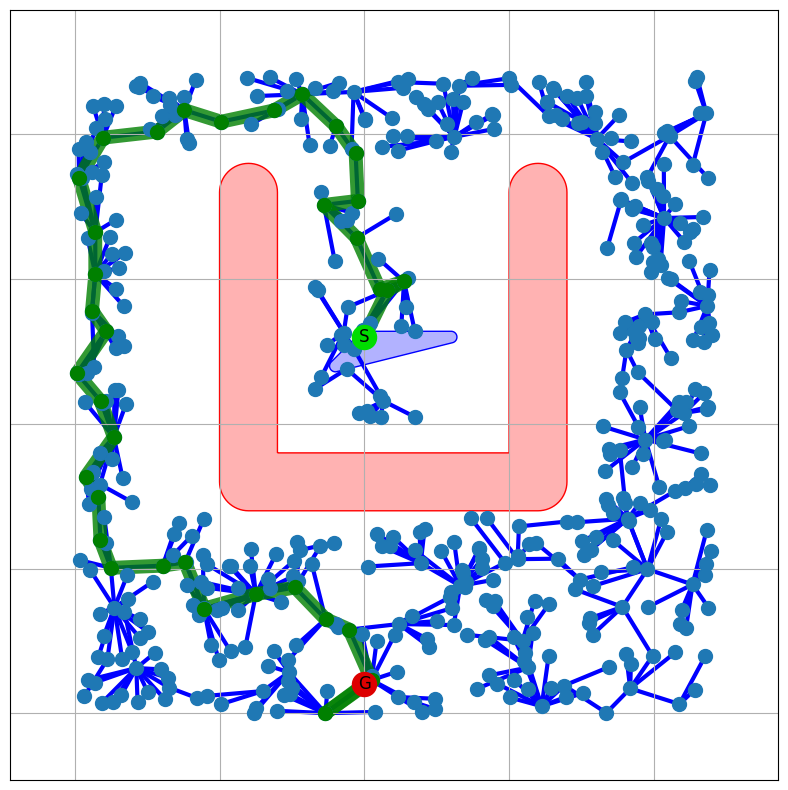

In [4]:
fig_local = plt.figure(figsize=(10,10))
ax = fig_local.add_subplot(1,1,1)
basicPRMVisualize(basicPRM.graph,environment,solution,ax=ax)

## Interactive testing

In [ ]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [ ]:
@interact(radius=(0.5, 10.0), numNodes=(10,1000,10), __manual=True)
def test(radius=5.0, numNodes=200):

    trapField = dict()
    trapField["obs1"] =   LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1.0)

    environment = CollisionChecker(trapField)

    basicPRM = BasicPRM(environment)
    basicConfig = dict()
    basicConfig["radius"] = radius
    basicConfig["numNodes"] = numNodes

    start = [[10,10]]
    goal  = [[10,1]]

    solution = basicPRM.planPath(start, goal, basicConfig)
    fig_local = plt.figure(figsize=(10,10))
    ax = fig_local.add_subplot(1,1,1)
    basicPRMVisualize(basicPRM.graph,environment,solution,ax=ax)

# "Capsulate" Visualization

It makes sense to put the visualization code in an extra module. Proposal to align the name of the module with the filename of the corresponding planning algorithm:

``` IPPRMBase.py --> IPVISBasicPRM.py ```

This allows something like:

In [ ]:
from IPBasicPRM import BasicPRM
from IPVISBasicPRM import basicPRMVisualize
from IPEnvironment import CollisionChecker
import matplotlib.pylab as plt

# Definition of a testing environment
trapField = dict()
trapField["obs1"] = LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1.0)

environment = CollisionChecker(trapField)

basicPRM = BasicPRM(environment)
basicConfig = dict()
basicConfig["radius"] = 3
basicConfig["numNodes"] = 300

start = [[10,10]]
goal  = [[10,1]]

solution = basicPRM.planPath(start, goal, basicConfig)

fig_local = plt.figure(figsize=(10,10))
ax = fig_local.add_subplot(1,1,1)
basicPRMVisualize(basicPRM,solution,ax=ax)


# Benchmarking

In [ ]:
import importlib
from shapely.geometry import Point, Polygon, LineString

In [ ]:
import IPTestSuite


In [ ]:
benchList = IPTestSuite.benchList[0:3] # only use first three benchmarks

In [ ]:
for benchmark in benchList:
    print(benchmark.name)

In [ ]:
from IPBasicPRM import BasicPRM
from IPVISBasicPRM import basicPRMVisualize
from IPEnvironment import CollisionChecker
import matplotlib.pylab as plt

basicConfig = dict()
basicConfig["radius"] = 5
basicConfig["numNodes"] = 200

for bench in benchList:
    try:
        fig_local = plt.figure(figsize=(10,10))
        ax = fig_local.add_subplot(1,1,1)
        basicPRM = BasicPRM(bench.collisionChecker)
        print("Planning", bench.name)
        solution = basicPRM.planPath(bench.startList, bench.goalList, basicConfig)
        title = bench.name
        if solution == []:
            title += " (No path found!)"
        title += "\n Assumed complexity level " + str(bench.level)
        ax.set_title(title)
        basicPRMVisualize(basicPRM,solution,ax=ax)
    except Exception as e:
        print("ERROR: ",bench.name, e)
        
    